## Validation experiment on PointOdyssey dataset

We validate the estimated mutual information result on PointOdyssey dataset (can be download [here](https://drive.google.com/drive/u/0/folders/1lMMHMXrTaFZEugD8ABScvrkmGGSqDe2f)). This experiment show the result of MI on the trajectories between one select point and all other points in a video.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
## path to the root directory
%cd /content/drive/MyDrive/InfoNet-main
print("Current working directory:", os.getcwd())

/content/drive/MyDrive/InfoNet-main
Current working directory: /content/drive/MyDrive/InfoNet-main


### Preprocess trajectories

Import packages

In [3]:
import matplotlib.pyplot as plt
import cv2
import numpy as np

In [4]:
data_root_path = "/content/drive/MyDrive/Datasets/animal2_s"
track_save_path = "/content/drive/MyDrive/Datasets/tracks"

In [5]:
src_file_path = os.path.join(data_root_path, "annotations.npz")
if os.path.isfile(src_file_path):
    gt_dict = np.load(src_file_path, allow_pickle=True)
    track2d = gt_dict['trajs_2d']
    valid_idx_set2d = set(range(track2d.shape[1]))

    for frame_idx in range(track2d.shape[0]):
        ## ensure all the points show up in the first image
        if frame_idx==0:
            frame_data = track2d[frame_idx]
            invalid_idx = np.where( (frame_data[:, 0] < 0) | (frame_data[:, 0] > 960) |
                                           (frame_data[:, 1] < 0) | (frame_data[:, 1] > 540))[0]
            valid_idx_set2d -= set(invalid_idx)

        frame_data = track2d[frame_idx]
        invalid_idx = np.where( (frame_data[:, 0] <= -2000) | (frame_data[:, 0] >= 2000) |
                                        (frame_data[:, 1] <= -2000) | (frame_data[:, 1] >= 2000))[0]

        valid_idx_set2d -= set(invalid_idx)

    valid_idx_list2d = list(valid_idx_set2d)

    print(f"valid points are {len(valid_idx_list2d)}")
    valid_2d = track2d[:, valid_idx_list2d, :]
    print(f"trajectory shape is {valid_2d.shape}")

    dest_dir = os.path.join(track_save_path, "animal2_s")
    os.makedirs(dest_dir, exist_ok=True)
    dest_file_path2d = os.path.join(dest_dir, "trajs_2d.npy")
    np.save(dest_file_path2d, valid_2d)

valid points are 4404
trajectory shape is (1181, 4404, 2)


### Compute mutual information between the trajectory of one select point and all other points

load checkpoint

In [6]:
import numpy as np
import pickle
from sklearn.mixture import GaussianMixture
from sklearn.mixture._gaussian_mixture import _estimate_log_gaussian_prob, _compute_precision_cholesky, _estimate_gaussian_covariances_full
from scipy.special import logsumexp
import torch
from model.decoder import Decoder
from model.encoder import Encoder
from model.infonet import infonet
from model.query import Query_Gen_transformer
from scipy.stats import rankdata

latent_dim = 256
latent_num = 256
input_dim = 2
batchsize = 32  #### num of distributions trained in one epoch
seq_len = 5000  #### number of data points sampled from each distribution
decoder_query_dim = 1000
learning_rate = 0.0002
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

encoder = Encoder(
    input_dim=input_dim,
    latent_num=latent_num,
    latent_dim=latent_dim,
    cross_attn_heads=8,
    self_attn_heads=16,
    num_self_attn_per_block=8,
    num_self_attn_blocks=1
)

decoder = Decoder(
    q_dim=decoder_query_dim,
    latent_dim=latent_dim,
)

query_gen = Query_Gen_transformer(
    input_dim = input_dim,
    dim = decoder_query_dim
)

model = infonet(encoder=encoder, decoder=decoder, query_gen = query_gen, decoder_query_dim = decoder_query_dim).to(device)
ckpt_path = os.path.join('saved', 'uniform', 'model_5000_32_1000-720--0.16.pt')
model.load_state_dict(torch.load(ckpt_path, map_location=device))

<All keys matched successfully>

In [17]:
def estimate_mi(model, x, y):
    ## x and y are 1 dimensional sequences
    model.eval()
    x = rankdata(x)/len(x)
    y = rankdata(y)/len(y)
    batch = torch.stack((torch.tensor(x, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)), dim=1).unsqueeze(0).to(device) ## batch has shape [1, sequence length, 2]
    with torch.no_grad():
        mi_lb = model(batch)
    return mi_lb

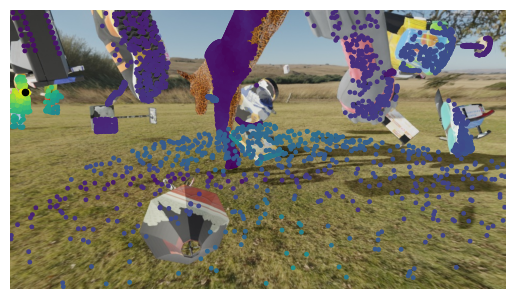

In [20]:
track_root_dir = "/content/drive/MyDrive/Datasets/tracks"
track_path = os.path.join(track_root_dir, "animal2_s")
track_file_path = os.path.join(track_path, "trajs_2d.npy")
track = np.load(track_file_path)
idx = 1800 ## select one point

results = []
x_values = track[:, :, 0]
y_values = track[:, :, 1]

for i in range(track.shape[1]):
    mi_x = estimate_mi(model, x_values[:,i], x_values[:,idx])
    mi_y = estimate_mi(model, y_values[:,i], y_values[:,idx])
    result = ((mi_x + mi_y)/2)
    results.append(result.cpu().numpy())

results = np.array(results)
mi_save_dir = "/content/drive/MyDrive/InfoNet-main/track_results"
mi_file_path = os.path.join(mi_save_dir, f"animal2_s_{idx}.npy")
np.save(mi_file_path, results)


image = cv2.imread(os.path.join(data_root_path, 'rgbs/rgb_00001.jpg'))
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
location = track[0]
point = location[idx]
plt.clf()
plt.imshow(image)
plt.scatter(location[:, 0], location[:, 1], c=results, cmap='viridis', s=6)
plt.scatter(point[0], point[1], c='black', s=20)
plt.axis('off')
plt.show()